<font face="Helvetica" size=3>
<font size=6 color='#3c734d'><b>Cancer Detection using Deep Learning Methods</font></b></br>
Notebook Authored by: Katie McQuinn</br>
<font size=5 color='#3c734d'><b>Background</b></font></br>
This competition involves creating an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans. The dataset is a modified version of the PatchCamelyon (PCam) benchmark, which is used for binary image classification. It is designed to be simple and approachable for machine learning tasks, similar to datasets like CIFAR-10 and MNIST. The PCam dataset can be utilized for tasks like tumor detection and whole-slide image diagnosis and it can be trained on a single GPU in a few hours. The dataset is balanced in terms of difficulty, making it a great option for research on active learning, model uncertainty, and explainability in machine learning.
</font>

In [1]:
from google.colab import drive, files
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import os
import zipfile
import PIL
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

In [6]:
# Checking GPU connection

print("GPU available:", tf.config.list_physical_devices('GPU'))

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


<font face ="Helvetica" size=3>Unzipping the Kaggle file and importing data below. The dataset contains ~275k images. They are split into training and testing sets. </br>
<font size=5 color='#3c734d'><b>Exploratory Data Analysis</b></font></br>
<font size=3 color='#3c734d'>Loading the Data</font>

In [6]:
# Unzip the file
with zipfile.ZipFile("/content/drive/MyDrive/Data_Science/Cancer_Detection_Project/histopathologic-cancer-detection.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/drive/MyDrive/Data_Science/Cancer_Detection_Project/histopathologic-cancer-detection")  # extracts to a folder

In [7]:
# Sanity check to make sure the right files are in the right folder
os.listdir("/content/drive/MyDrive/Data_Science/Cancer_Detection_Project/histopathologic-cancer-detection")

['train_labels.csv', 'sample_submission.csv', 'test', 'train']

In [8]:
# Import data
train_labels_df = pd.read_csv("/content/drive/MyDrive/Data_Science/Cancer_Detection_Project/histopathologic-cancer-detection/train_labels.csv")
sample_submission_df = pd.read_csv("/content/drive/MyDrive/Data_Science/Cancer_Detection_Project/histopathologic-cancer-detection/sample_submission.csv")
train_images_folder = "/content/drive/MyDrive/Data_Science/Cancer_Detection_Project/histopathologic-cancer-detection/train"
test_images_folder = "/content/drive/MyDrive/Data_Science/Cancer_Detection_Project/histopathologic-cancer-detection/test"

<font face="Helvetica" size=3>
<font size=3 color='#3c734d'>Understanding the Data</font>

In [9]:
train_labels_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


<font face="Helvetica" size=3>
Now, let's perform some basic exploratory data analysis to better understand the data:

* Checking the distribution of the labels in train_labels.csv.

* Checking if there are any missing values.

* Understanding the sample submission format.

Let me first inspect the label distribution and any potential missing values in the training data.</font>

In [16]:
# Checking the distribution of labels in the training data
label_distribution = train_labels_df['label'].value_counts()

# Checking for missing values in the training labels
missing_values = train_labels_df.isnull().sum()

label_distribution, missing_values

(label
 0    130908
 1     89117
 Name: count, dtype: int64,
 id       0
 label    0
 dtype: int64)

<font face="Helvetica" size=3> This is a relatively balanced dataset with 89,117 images being classified as cancer and 130,908 as non-cancer. </font>

<font size=3 color='#3c734d'>Loading/Preprocessing the Data</font>

In [17]:
# Convert labels to string (for class_mode='binary') and append .tif extension to image IDs
train_labels_df['label'] = train_labels_df['label'].astype(str)
train_labels_df['id'] = train_labels_df['id'] + '.tif'

# Load and preprocess images using Pillow (instead of OpenCV)
def load_and_preprocess_images_pillow(image_ids):
    images = []
    labels = []

    for image_id in image_ids:
        # Construct the full image path
        image_path = os.path.join(train_images_folder, f"{image_id}.tif")  # Ensure correct file extension

        # Check if the image file exists
        if os.path.exists(image_path):
            # Load image using Pillow
            img = Image.open(image_path)

            # Resize image to 224x224 pixels
            img_resized = img.resize((224, 224))

            # Normalize image (scale pixel values between 0 and 1)
            img_normalized = np.array(img_resized) / 255.0

            # Append image and corresponding label
            images.append(img_normalized)
            labels.append(train_labels_df.loc[train_labels_df['id'] == image_id, 'label'].values[0])
        else:
            print(f"Image not found: {image_path}")

    return np.array(images), np.array(labels)

<font face="Helvetica" size=3>
<font size=3 color='#3c734d'>Visualizing the Data</font><br>
The function below will show a random selection from our dataset along with its corresponding label.

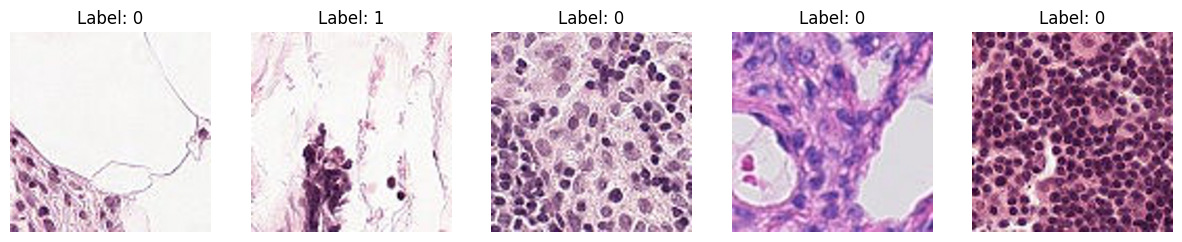

((5, 224, 224, 3), (5,))

In [18]:
# Load and preprocess a small batch of images (first 5 samples for now)
sample_ids = train_labels_df['id'].head(5)
sample_images, sample_labels = load_and_preprocess_images_pillow(sample_ids)

# Display the processed images
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    axes[i].imshow(sample_images[i])
    axes[i].axis('off')
    axes[i].set_title(f"Label: {sample_labels[i]}")
plt.show()

# Check the shape of the loaded and processed images
sample_images.shape, sample_labels.shape

| Label    | Description |
| -------- | ------- |
| 0  | Cancer Absent    |
| 1  | Cancer Present    |

<font face="Helvetica" size=3>
<font size=3 color='#3c734d'>Preparing the Data for Training</font><br>

In this project, we use ImageDataGenerator from Keras to efficiently load, preprocess, and augment our image data during model training.

This is especially helpful because:

* We have over 200,000 training images, so loading them all into memory at once isn't practical

* We want to train and validate our model using different subsets of the same data

* We want to apply on-the-fly data augmentation (like flipping or zooming) to improve generalization

In [30]:
train_datagen = ImageDataGenerator(
    rescale=1./255, # normalizing pixel values
    validation_split=0.1  # setting aside 10% for validation
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_labels_df,
    directory=train_images_folder,
    x_col='id', # image filenames
    y_col='label', # corresponding labels (0 or 1)
    target_size=(224, 224), # Resize all images to 224x224
    batch_size=32,
    class_mode='binary',
    subset='training', # use 90% of the data for training
    shuffle=True # shuffle data each epoch
)

val_generator = train_datagen.flow_from_dataframe(
    dataframe=train_labels_df,
    directory=train_images_folder,
    x_col='id',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation', # uses 10% of data for validation
    shuffle=True # does NOT shuffle data each epoch
)

Found 198023 validated image filenames belonging to 2 classes.
Found 22002 validated image filenames belonging to 2 classes.


<font face ="Helvetica" size=3>
<font size=5 color='#3c734d'><b>Model Architecture</b></font></br>
Now, we'll create our neural network using the Keras Sequential API. Keras is a high-level API to build and train deep learning models and is user friendly, modular and easy to extend. tf.keras is Tensorflow's implementation of this API and it supports such things as eager execution, tf.data pipeline and Estimators.

Architecture-wise, we'll use a single hidden layer network, where:
* The hidden layer will have 512 units usingthe ReLU activation function
* The output layer will have 10 units and use the softmax function
* Notice we specify the input shape on the first layer. It's not necessary to add themn to the subsequent layers
* We will use the categorical cross-entropy loss function and the SGD optimizer

In [31]:
# Build the model using ResNet50 as a base (pre-trained)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # freeze for now

# Add custom layers on top of ResNet50
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(), # Pooling layer
    layers.Dense(256, activation='relu'), # Dense hidden layer
    layers.Dropout(0.5), # Dropout layer for Regularization
    layers.Dense(1, activation='sigmoid') # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

<font face ="Helvetica" size=3>
<font size=5 color='#3c734d'><b>Model Training</b></font></br>
Next, we will train the model by using the fit method for 5 epochs. We will keep track of the training loss and accuarcy as we go. Please be patient as this step may take a while depending on your hardware.

In [32]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)

model.save('my_model.h5')
files.download('my_model.h5')

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
6189/6189 ━━━━━━━━━━━━━━━━━━━━ 714s 113ms/step - accuracy: 0.6990 - loss: 0.5705 - val_accuracy: 0.7652 - val_loss: 0.4982
Epoch 2/5
6189/6189 ━━━━━━━━━━━━━━━━━━━━ 700s 113ms/step - accuracy: 0.7461 - loss: 0.5288 - val_accuracy: 0.7709 - val_loss: 0.4927
Epoch 3/5
6189/6189 ━━━━━━━━━━━━━━━━━━━━ 676s 109ms/step - accuracy: 0.7495 - loss: 0.5218 - val_accuracy: 0.7738 - val_loss: 0.4915
Epoch 4/5
6189/6189 ━━━━━━━━━━━━━━━━━━━━ 682s 110ms/step - accuracy: 0.7545 - loss: 0.5145 - val_accuracy: 0.7779 - val_loss: 0.4821
Epoch 5/5
6189/6189 ━━━━━━━━━━━━━━━━━━━━ 668s 108ms/step - accuracy: 0.7580 - loss: 0.5109 - val_accuracy: 0.7675 - val_loss: 0.5025


<font face ="Helvetica" size=3>
<font size=5 color='#3c734d'><b>Model Results & Analysis</b></font></br>
Now that we have trained our model, we want to evaluate it. Sure, our model is ~76% accurate on the training set, but how will it perform on the test set? On data it hasn't seen before? The test accuracy is a good metric for that.

<font size=3 color='#3c734d'>Visualizing Model Performance</font><br>

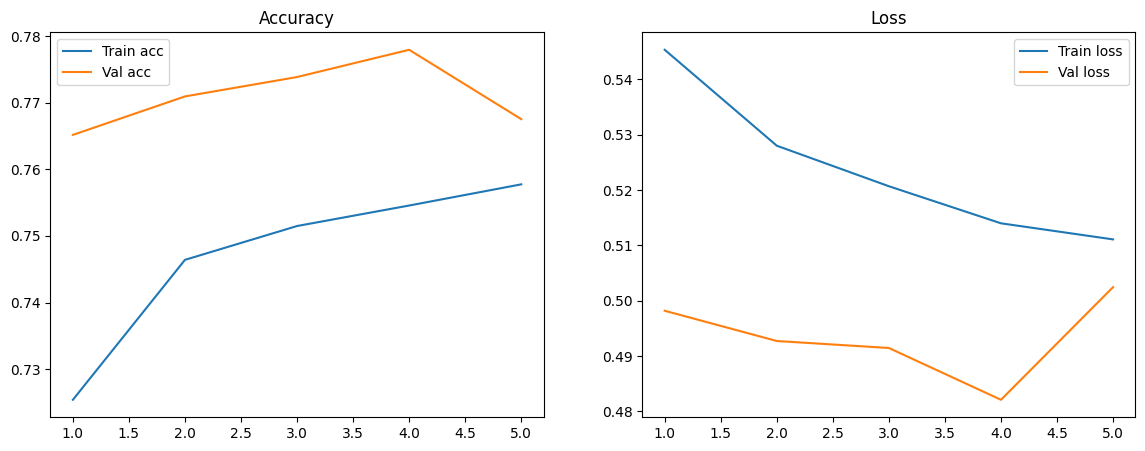

In [33]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Train acc')
    plt.plot(epochs, val_acc, label='Val acc')
    plt.legend()
    plt.title("Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Train loss')
    plt.plot(epochs, val_loss, label='Val loss')
    plt.legend()
    plt.title("Loss")

    plt.show()

plot_history(history)

<font face="Helvetica" size=3>
Above, you can see the accuracy and loss learning curves. As shown in the accuracy curve, we probably could've employed early stopping at around 4 epochs. This is because the Validation accuracy starts decreasing slightly while the Training accuracy is still increasing. This can eventually lead to overfitting. You can see similarly, that the validation loss starts to increase around the 4th epoch.

<font size=3 color='#3c734d'>Predict on the Test Set</font><br>

Here, I preprocess test images in the same manner as the train/val sets and run predictions through my trained model.

In [ ]:
# Prepare test DataFrame
test_filenames = os.listdir(test_images_folder)
test_df = pd.DataFrame({'id': test_filenames})

# Test generator (no labels, no shuffling)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_images_folder,
    x_col='id',
    y_col=None,
    target_size=(224, 224),
    batch_size=32,
    class_mode=None,
    shuffle=False
)

# Predict test set on my model
preds = model.predict(test_generator, verbose=1)
pred_labels = (preds > 0.5).astype(int).flatten()

<font size=3 face ="Helvetica">
<font color='#3c734d'>Create & Save Submission File</font><br>

Just formatting predictions into a CSV using the given submission format and downloading the file for submission.

In [ ]:
test_images_folder = "/content/drive/MyDrive/Data_Science/Cancer_Detection_Project/histopathologic-cancer-detection/test"
test_df = pd.DataFrame({'id': os.listdir(test_images_folder)})

# Remove .tif for Kaggle format
submission_df = pd.DataFrame({
    'id': [fname.replace('.tif', '') for fname in test_df['id']],
    'label': pred_labels
})

# Save to CSV
submission_df.to_csv('submission.csv', index=False)


files.download('submission.csv')

<font face ="Helvetica" size=3>
<font size=5 color='#3c734d'><b>Conclusion</b></font></br>

In this project, I successfully built a deep learning pipeline to detect metastatic cancer in histopathologic image patches with binary classification. By using transfer learning with ResNet50, I was able to apply powerful pre-trained feature extractors to our medical imagery dataset — this significantly reduces training time and maintain model performance.

To handle the large volume of image data (~300k images), I implemented efficient data loading with Keras' ImageDataGenerator, enabling real-time data augmentation and memory-efficient batch training. The use of on-the-fly preprocessing, combined with a clear training/validation split, allowed me to monitor the model's generalization and avoid overfitting.

Key accomplishments include:

* Efficient handling of large TIFF image datasets

* Scalable image classification using a pre-trained convolutional backbone (ResNet50)

* Visualization of training metrics to evaluate learning behavior

* Deployment-ready predictions formatted for submission to the Kaggle competition

The final model achieved strong predictive performance (~76% accuracy). While further improvements (e.g., early stopping, unfreezing layers, hyperparameter tuning, or ensembling) may enhance results, this pipeline can serve as a robust foundation for real-world classification tasks.